# Generate Plots of Conversion Data

**Goal**: Visualize summary statistics of conversions.

In [1]:
import bd_mysql
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

sns.set;
%matplotlib inline

## Import and pre-process data

In [2]:
# Connect to database
config_path = '/Users/lindsay/Documents/Data Science/BrazilianDirect/cfg/mysql.cfg'
myDB = bd_mysql.connect_bd_mysql(config_path)

# Download data
df = bd_mysql.download_quote_data(myDB)

# Preprocess data
df = bd_mysql.pre_process_mysql(df)

## Plot quotes and conversion rates

In [3]:
# Convert year to int
df['year'] = df['year'].astype(int)

In [4]:
# group by year
gb_year = df.groupby('year')

In [5]:
# calculate yearly quotes
yearly_quotes = pd.DataFrame(df['year'].value_counts()).reset_index()
yearly_quotes.columns = ['year', 'quotes']

In [6]:
# calculate yearly conversions and rates
yearly_conversion = pd.DataFrame(gb_year['converted'].agg(np.sum)).reset_index()
yearly_conversion.columns = ['year', 'converted']

yearly_conv_rate = pd.DataFrame(gb_year['converted'].agg(np.mean)).reset_index()
yearly_conv_rate['converted'] = yearly_conv_rate['converted'] * 100
yearly_conv_rate.columns = ['year', 'conversion rate']

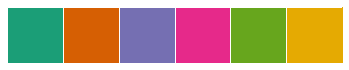

In [7]:
color_palette = sns.color_palette('Dark2')
sns.palplot(color_palette)

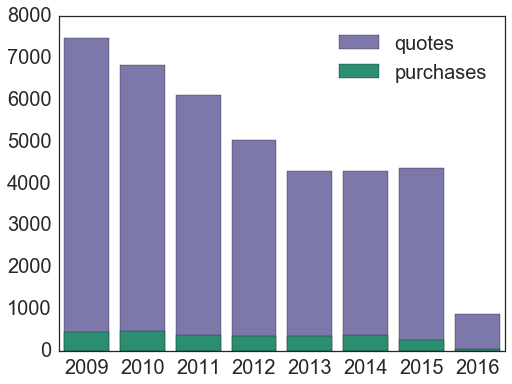

In [8]:
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
fig = plt.figure()
fig.set_size_inches(8, 6)

ax = fig.add_subplot(111)
sns.barplot(x = 'year', 
            y = 'quotes', 
            data = yearly_quotes, 
            color = color_palette[2], 
            label = 'quotes');
sns.barplot(x = 'year', 
            y = 'converted', 
            data = yearly_conversion, 
            color = color_palette[0],
            label = 'purchases');
plt.legend();
plt.xlabel('');
plt.ylabel('');

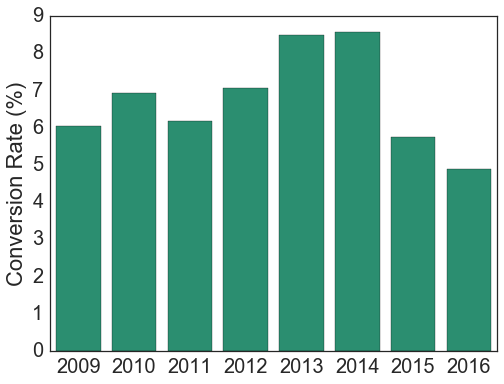

In [9]:
sns.set_style('white')
fig, ax = plt.subplots()
sns.barplot(x = 'year', y = 'conversion rate', data = yearly_conv_rate, color = color_palette[0]);
ax.set_xlabel('');
ax.set_ylabel('Conversion Rate (%)');
fig.set_size_inches(8,6)

In order to understand why the decrease, might be useful to perform specific comparisons of 2014 vs 2015.

## Compare 2014 vs 2015

### Species

In [10]:
df_14_15 = df.loc[df['year'].isin([2014, 2015]), :]

In [11]:
xt_species_year = pd.crosstab(df_14_15['common_name'], [df_14_15['year'], df_14_15['converted']]).reset_index()
xt_species_year

year               common_name  2014       2015    
converted                          0    1     0   1
0                     Amendoim   175   26   121  15
1             Brazilian Cherry  1482  131  2152  99
2               Brazilian Teak   562   56   433  41
3             Brazilian Walnut   455   33   380  25
4                        Other   105    4    88   7
5          Patagonian Rosewood   100   17   108   8
6              Santos Mahogany   431   43   426  29
7               Tiete Rosewood   143   23    81   8
8                    Tigerwood   477   35   321  19

In [12]:
xt_species_year[2014, 'conv_rate'] = xt_species_year[2014, 1] / (xt_species_year[2014, 0] + xt_species_year[2014, 1])
xt_species_year[2015, 'conv_rate'] = xt_species_year[2015, 1] / (xt_species_year[2015, 0] + xt_species_year[2015, 1])

In [13]:
xt_species_year.sort_values([(2015, 1)], ascending = False)

year               common_name  2014       2015          2014      2015
converted                          0    1     0   1 conv_rate conv_rate
1             Brazilian Cherry  1482  131  2152  99  0.081215  0.043980
2               Brazilian Teak   562   56   433  41  0.090615  0.086498
6              Santos Mahogany   431   43   426  29  0.090717  0.063736
3             Brazilian Walnut   455   33   380  25  0.067623  0.061728
8                    Tigerwood   477   35   321  19  0.068359  0.055882
0                     Amendoim   175   26   121  15  0.129353  0.110294
5          Patagonian Rosewood   100   17   108   8  0.145299  0.068966
7               Tiete Rosewood   143   23    81   8  0.138554  0.089888
4                        Other   105    4    88   7  0.036697  0.073684

#### Put data for raw quotes/conversions and rates into tidy format

In [15]:
tidy_xt_species_year = pd.melt(xt_species_year, id_vars='common_name')

In [33]:
tidy_xt_species_year_converted = tidy_xt_species_year.loc[tidy_xt_species_year['converted'].isin([0,1]), :]
tidy_xt_species_year_rate = tidy_xt_species_year.loc[tidy_xt_species_year['converted'] == 'conv_rate', :]

tidy_xt_species_year_converted.columns = ['common_name', 'year', 'conversion_status', 'count']

tidy_xt_species_year_rate = tidy_xt_species_year_rate.drop('converted', axis=1)
tidy_xt_species_year_rate.columns = ['common_name', 'year', 'conversion_rate']
tidy_xt_species_year_rate['conversion_rate'] = tidy_xt_species_year_rate['conversion_rate'] * 100

In [34]:
species_conversions = pd.merge(tidy_xt_species_year_converted, tidy_xt_species_year_rate, on = ['common_name', 'year'])

In [35]:
species_conversions = species_conversions.sort_values(['count', 'common_name', 'year'], ascending=False)

In [50]:
species_conversions.head()

,common_name,year,conversion_status,count,conversion_rate
20,Brazilian Cherry,2015,0,2152.0,4.398045
2,Brazilian Cherry,2014,0,1482.0,8.121513
4,Brazilian Teak,2014,0,562.0,9.061489
16,Tigerwood,2014,0,477.0,6.835938
6,Brazilian Walnut,2014,0,455.0,6.762295


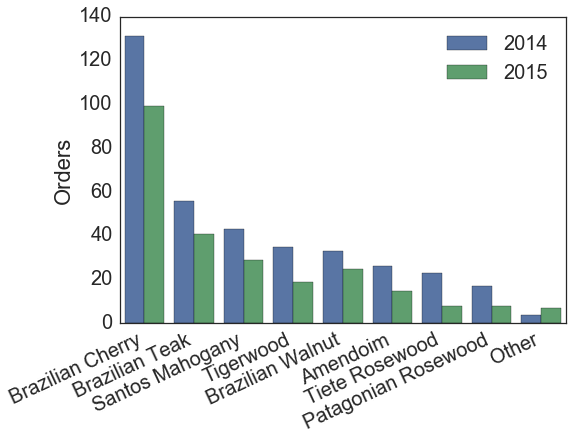

In [55]:
ax = sns.barplot(x='common_name', 
            y='count', 
            data = species_conversions.loc[species_conversions['conversion_status'] == 1, :], 
            hue='year');
fig.set_size_inches(8,6)
plt.xlabel('');
plt.ylabel('Orders');
plt.legend(title=False, loc = 'best');
[x.set_rotation(25) for x in ax.get_xticklabels()];
[x.set_horizontalalignment('right') for x in ax.get_xticklabels()];

In [61]:
species_quotes = species_conversions.groupby(['common_name', 'year']).agg(np.sum).reset_index().drop('conversion_rate', axis=1).sort_values('count', ascending=False)

In [62]:
species_quotes.head()

,common_name,year,count
3,Brazilian Cherry,2015,2251.0
2,Brazilian Cherry,2014,1613.0
4,Brazilian Teak,2014,618.0
16,Tigerwood,2014,512.0
6,Brazilian Walnut,2014,488.0


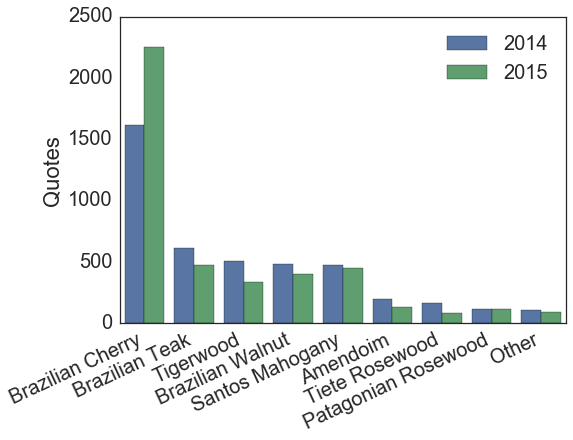

In [63]:
ax = sns.barplot(x='common_name', 
            y='count', 
            data = species_quotes, 
            hue='year');
fig.set_size_inches(8,6)
plt.xlabel('');
plt.ylabel('Quotes');
plt.legend(title=False, loc = 'best');
[x.set_rotation(25) for x in ax.get_xticklabels()];
[x.set_horizontalalignment('right') for x in ax.get_xticklabels()];

In [68]:
species_month_year = df_14_15.loc[:, ['common_name', 'year', 'month', 'converted']].groupby(['year', 'month', 'common_name'])

In [73]:
quotes_species_month_year = pd.DataFrame(species_month_year.size()).reset_index()
quotes_species_month_year.columns = ['year', 'month', 'common_name', 'count']
quotes_species_month_year['month'] = quotes_species_month_year['month'].astype(int)

In [75]:
bc_quotes = quotes_species_month_year.loc[quotes_species_month_year['common_name'] == 'Brazilian Cherry', :]

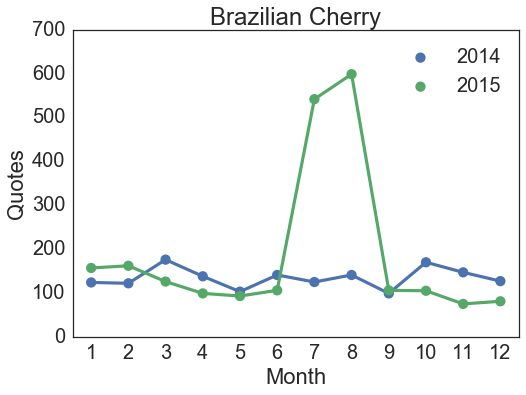

In [84]:
sns.pointplot(x = 'month', y = 'count', data = bc_quotes, hue = 'year');
plt.xlabel('Month');
plt.ylabel('Quotes');
plt.legend(title=False);
plt.title('Brazilian Cherry');

In [87]:
peak_bc_quotes = df_14_15.loc[(df_14_15['year'] == 2015) & (df_14_15['month'].isin([7,8])) & (df_14_15['common_name'] == 'Brazilian Cherry'), :]

In [94]:
df_14_15.loc[(df_14_15['year'] == 2015) & (df_14_15['month'].isin([9,10])) & (df_14_15['common_name'] == 'Brazilian Cherry'), 'sq_ft'].value_counts()

500.0      47
1000.0     19
1500.0     17
1200.0     11
1100.0     11
600.0      10
2000.0      8
700.0       7
900.0       6
3000.0      5
1400.0      4
1350.0      3
750.0       3
1700.0      3
2200.0      3
2500.0      3
1600.0      2
2100.0      2
650.0       2
550.0       2
800.0       2
850.0       2
880.0       2
2160.0      2
535.0       2
2300.0      2
1420.0      1
12500.0     1
1800.0      1
607.0       1
1300.0      1
2800.0      1
539.0       1
1515.0      1
530.0       1
2600.0      1
555.0       1
1840.0      1
1250.0      1
827.0       1
830.0       1
715.0       1
5000.0      1
2750.0      1
2356.0      1
775.0       1
860.0       1
861.0       1
950.0       1
2400.0      1
870.0       1
693.0       1
630.0       1
660.0       1
1150.0      1
1424.0      1
1031.0      1
Name: sq_ft, dtype: int64

In [97]:
peak_bc_quotes['email'].value_counts()

none@nwfa.org                                 9
rnmitch500@gmail.com                          3
customfloors@chartertn.net                    3
PFAHEY@CLEMLUMBER.COM                         2
jdz@horizonforest.com                         2
mcnmac73@gmail.com                            2
RickH@derrflooring.com                        2
dan@clousefloors.com                          2
tim@southerncpt.com                           2
hardwoodinspector@gmail.com                   2
hardwoodsolutions@earthlink.net               2
lori.mitchell-keller@sap.com                  2
Greek-angel@live.com                          2
reosrc@gmail.com                              2
carole.akoury@chabros.com                     2
paulina0218@gmail.com                         2
wilsonfloors@aol.com                          2
asmithllc@msn.com                             2
bdansie@infinitehardwood.com                  2
psaulnier@saulnierfloors.com                  2
marcos@cmchardwoodfloors.com            

In [93]:
peak_bc_quotes['sq_ft'].value_counts()

777.0      442
1000.0     169
787.0      107
877.0       94
687.0       76
878.0       50
500.0       40
677.0       29
1200.0      13
600.0       10
700.0        8
900.0        7
2000.0       7
800.0        6
1600.0       6
1500.0       5
3000.0       4
650.0        4
1100.0       4
2700.0       3
3800.0       2
1850.0       2
1800.0       2
825.0        2
850.0        2
4000.0       2
560.0        2
525.0        2
1111.0       2
2500.0       2
          ... 
625.0        1
520.0        1
1825.0       1
1900.0       1
8000.0       1
512.0        1
556.0        1
530.0        1
680.0        1
1400.0       1
10000.0      1
750.0        1
1250.0       1
1224.0       1
1212.0       1
1156.0       1
3200.0       1
1056.0       1
1010.0       1
950.0        1
925.0        1
910.0        1
1675.0       1
1700.0       1
876.0        1
790.0        1
1320.0       1
780.0        1
759.0        1
2100.0       1
Name: sq_ft, dtype: int64

In [95]:
peak_bc_quotes['date_created'].value_counts()

2015-08-06    360
2015-07-29    286
2015-08-09    156
2015-07-28    143
2015-07-27     25
2015-07-08      9
2015-07-07      8
2015-07-19      8
2015-08-03      7
2015-07-01      7
2015-07-24      6
2015-08-13      6
2015-07-25      5
2015-08-08      5
2015-08-28      5
2015-08-29      5
2015-07-31      4
2015-07-22      4
2015-07-10      4
2015-08-31      4
2015-08-14      4
2015-07-18      4
2015-08-16      4
2015-08-19      4
2015-08-18      4
2015-08-25      3
2015-07-12      3
2015-08-27      3
2015-07-14      3
2015-08-17      3
2015-08-10      3
2015-08-12      3
2015-08-26      3
2015-08-24      3
2015-07-11      3
2015-08-22      3
2015-07-09      3
2015-07-02      2
2015-07-06      2
2015-07-23      2
2015-07-26      2
2015-08-23      2
2015-08-07      2
2015-07-13      2
2015-07-30      2
2015-08-04      1
2015-07-17      1
2015-08-02      1
2015-07-21      1
2015-08-15      1
2015-07-03      1
2015-08-11      1
2015-08-30      1
2015-07-04      1
2015-07-15      1
2015-08-20

**Conclusions**: Dan did some kind of promotional campaign for hardwood flooring professionals. It didn't work.

In [98]:
df_14_15.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'phone_provided', u'ship_state', u'install_subfloor', u'employee_id',
       u'sq_ft', u'cust_price', u'retail_price', u'common_name', u'finish',
       u'grade', u'milling', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month',
       u'year'],
      dtype='object')

In [106]:
df_14_15.groupby('year')['employee_id'].value_counts()

year  employee_id
2014  SO             1903
      NP             1483
      DC              580
      OTHER           332
2015  DC             1749
      SO             1675
      NP              611
      OTHER           326
dtype: int64

year
2014    Axes(0.125,0.125;0.775x0.775)
2015    Axes(0.125,0.125;0.775x0.775)
Name: cust_price, dtype: object

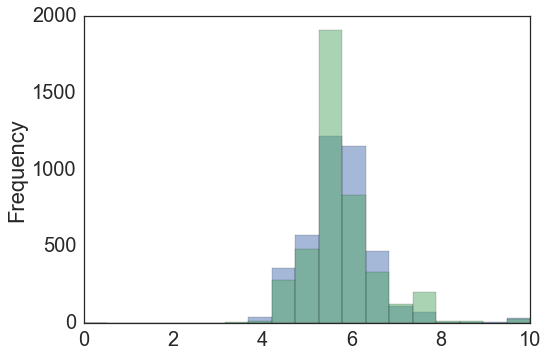

In [114]:
df_14_15.groupby('year')['cust_price'].plot.hist(bins = np.linspace(0, 10, 20), alpha=0.5)

In [116]:
df_14_15.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'phone_provided', u'ship_state', u'install_subfloor', u'employee_id',
       u'sq_ft', u'cust_price', u'retail_price', u'common_name', u'finish',
       u'grade', u'milling', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month',
       u'year'],
      dtype='object')

In [122]:
# exclude weird square footages
df_14_15_no_crazy = df_14_15.loc[df_14_15['sq_ft']%10 == 0, :]

In [140]:
xt_monthly_conversion = pd.DataFrame(df_14_15_no_crazy.groupby(['year', 'month'])['converted'].agg(np.mean)).reset_index()

In [141]:
xt_monthly_conversion.head()

,year,month,converted
0,2014,1.0,0.069277
1,2014,2.0,0.086567
2,2014,3.0,0.073733
3,2014,4.0,0.060000
4,2014,5.0,0.083333


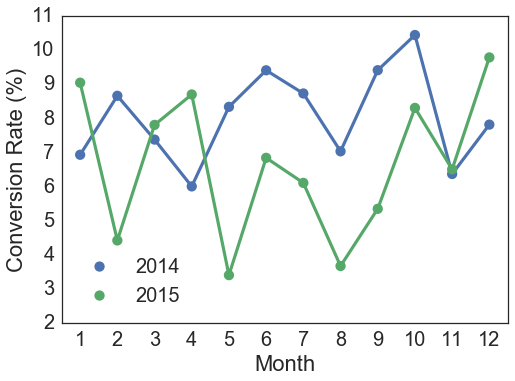

In [142]:
xt_monthly_conversion['month'] = xt_monthly_conversion['month'].astype(int)
xt_monthly_conversion['converted'] = xt_monthly_conversion['converted'] * 100
sns.pointplot(x = 'month', y = 'converted', data = xt_monthly_conversion, hue='year');
plt.legend(loc='best');
plt.xlabel('Month');
plt.ylabel('Conversion Rate (%)');

In [147]:
df['month'] = df['month'].astype(int)

In [148]:
df_no_crazy = df.loc[df['sq_ft']%10 == 0, :]

In [156]:
monthly_conversions = pd.DataFrame(df_no_crazy.groupby(['year', 'month'])['converted'].agg(np.mean)).reset_index()

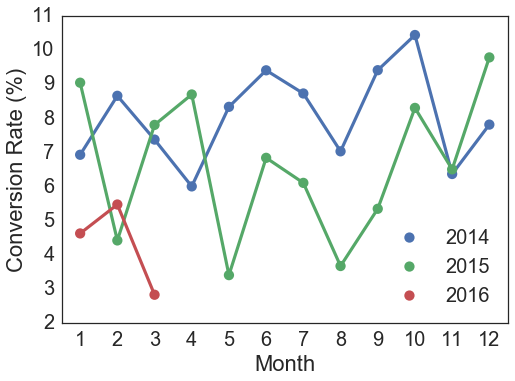

In [157]:
monthly_conversions['converted'] = monthly_conversions['converted'] * 100
sns.pointplot(x = 'month', y = 'converted', data = monthly_conversions.loc[monthly_conversions['year'] >= 2014, :], hue='year');
plt.legend(loc='best');
plt.xlabel('Month');
plt.ylabel('Conversion Rate (%)');

## Load CPA change history from ad words

In [158]:
filepath = '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/adwords/cpa_change_history.csv'
cpa = pd.read_csv(filepath, skiprows=1)

In [160]:
cpa.columns = ['date', 'user', 'campaign', 'ad_group', 'changes']

In [161]:
cpa['date'] = pd.to_datetime(cpa['date'])

In [162]:
cpa.head()

,date,user,campaign,ad_group,changes
0,2016-03-15 20:34:00,danc@brazilianhardwood.com,Brazilian Decking - Ipe MIAMI,Miami Local Ipe Decking,Ad group Target CPA increased from $32.77 to $...
1,2016-03-15 20:34:00,danc@brazilianhardwood.com,Brazilian Decking - Ipe MIAMI,Miami Local Ipe Decking,Ad group Target CPA increased from $32.37 to $...
2,2016-03-15 20:33:00,danc@brazilianhardwood.com,Santos Mahogany,Santos Ad,Ad group Target CPA increased from $37.77 to $...
3,2016-03-15 20:26:00,danc@brazilianhardwood.com,Brazilian Cherry - BD,Opts- Unfinished Brazilian Cherry,Ad group Target CPA increased from $27.77 to $...
4,2016-03-15 20:25:00,danc@brazilianhardwood.com,Brazilian Koa/Tigerwood,Ad Group #2,Ad group Target CPA decreased from $50.30 to $...


In [176]:
c = cpa.loc[0,'changes']
c

'Ad group Target CPA increased from $32.77 to $37.77'

In [177]:
import re

In [178]:
re.findall(r'CPA', c)

['CPA']

In [193]:
re.search(r'CPA', 'c')

In [194]:
cpa['change_type'] = [re.search(r'CPA', c) for c in cpa['changes']]

In [196]:
cpa.tail()

,date,user,campaign,ad_group,changes,change_type
2258,2014-04-04 17:10:00,danc@brazilianhardwood.com,GEO - BrazilianCherryOnly.com (Northeast),Solids,1 Broad match keyword max CPC decreased\n Cab...,None
2259,2014-04-04 17:10:00,danc@brazilianhardwood.com,GEO - BrazilianCherryOnly.com (Northeast),Solids,1 Broad match keyword max CPC decreased\n San...,None
2260,2014-04-04 17:10:00,danc@brazilianhardwood.com,GEO - BrazilianCherryOnly.com (Northeast),Solids,1 Broad match keyword max CPC decreased\n jat...,None
2261,2014-04-04 17:04:00,danc@brazilianhardwood.com,CoastalCumaru.com,Floor@Shore,Ad group Max CPC decreased from $3.75 to $0.77,None
2262,2014-04-04 16:53:00,danc@brazilianhardwood.com,Brazilian Cherry - BD,Opts- Unfinished Brazilian Cherry,Ad group Target CPA decreased from $25.00 to $...,<_sre.SRE_Match object at 0x10d54a510>


In [199]:
cpa = cpa.loc[pd.isnull(cpa['change_type']) == False, : ]

In [200]:
cpa['cpa'] = [re.findall(r'to \$(.*)', c) for c in cpa['changes']]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [202]:
cpa = cpa.drop('change_type', axis=1)

In [203]:
cpa['cpa'] = [float(x[0]) for x in cpa['cpa']]

In [204]:
cpa.head()

,date,user,campaign,ad_group,changes,cpa
0,2016-03-15 20:34:00,danc@brazilianhardwood.com,Brazilian Decking - Ipe MIAMI,Miami Local Ipe Decking,Ad group Target CPA increased from $32.77 to $...,37.77
1,2016-03-15 20:34:00,danc@brazilianhardwood.com,Brazilian Decking - Ipe MIAMI,Miami Local Ipe Decking,Ad group Target CPA increased from $32.37 to $...,32.77
2,2016-03-15 20:33:00,danc@brazilianhardwood.com,Santos Mahogany,Santos Ad,Ad group Target CPA increased from $37.77 to $...,44.77
3,2016-03-15 20:26:00,danc@brazilianhardwood.com,Brazilian Cherry - BD,Opts- Unfinished Brazilian Cherry,Ad group Target CPA increased from $27.77 to $...,32.77
4,2016-03-15 20:25:00,danc@brazilianhardwood.com,Brazilian Koa/Tigerwood,Ad Group #2,Ad group Target CPA decreased from $50.30 to $...,44.77


In [206]:
cpa['month'] = [x.month for x in cpa['date']]
cpa['year'] = [x.year for x in cpa['date']]

In [207]:
cpa.head()

,date,user,campaign,ad_group,changes,cpa,month,year
0,2016-03-15 20:34:00,danc@brazilianhardwood.com,Brazilian Decking - Ipe MIAMI,Miami Local Ipe Decking,Ad group Target CPA increased from $32.77 to $...,37.77,3,2016
1,2016-03-15 20:34:00,danc@brazilianhardwood.com,Brazilian Decking - Ipe MIAMI,Miami Local Ipe Decking,Ad group Target CPA increased from $32.37 to $...,32.77,3,2016
2,2016-03-15 20:33:00,danc@brazilianhardwood.com,Santos Mahogany,Santos Ad,Ad group Target CPA increased from $37.77 to $...,44.77,3,2016
3,2016-03-15 20:26:00,danc@brazilianhardwood.com,Brazilian Cherry - BD,Opts- Unfinished Brazilian Cherry,Ad group Target CPA increased from $27.77 to $...,32.77,3,2016
4,2016-03-15 20:25:00,danc@brazilianhardwood.com,Brazilian Koa/Tigerwood,Ad Group #2,Ad group Target CPA decreased from $50.30 to $...,44.77,3,2016


In [211]:
monthly_cpa = cpa.groupby(['campaign', 'year', 'month']).agg(np.mean).reset_index()

In [213]:
monthly_cpa['campaign'].value_counts()

Brazilian Cherry - BD                        16
Santos Mahogany                              12
GEO - RLC Kenilworth                         11
Brazilian Decking - Ipe MIAMI                11
Bolivian  Rosewood (Sabra)                    9
Cumaru/Walnut                                 9
Brazilian Cherry - BD_LOCAL                   9
Brazilian Decking - Ipe                       8
Brazilian Koa/Tigerwood                       8
Sapele                                        7
Cumaru/Walnut/Ipe/Teak Opt                    7
Amendoim                                      7
Sucupira/Tiete Chestnut                       4
JFLtd TERRA                                   4
Magento - Brazilian Direct                    4
CoastalCumaru.com                             4
Brazilian Cherry - BD_Dubai                   4
Geo - Decking                                 4
Jatoba Flooring - Brazilian Cherry            3
Wenge                                         3
Mobile - Brazilian Cherry               

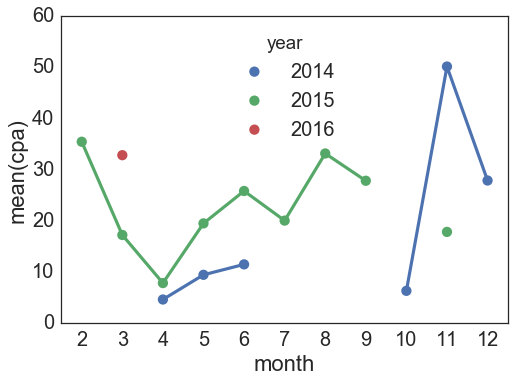

In [214]:
sns.pointplot(x='month', y='cpa', data=monthly_cpa.loc[monthly_cpa['campaign'] == 'Brazilian Cherry - BD', :], hue='year')

In [215]:
monthly_conversions.head()

,year,month,converted
0,2009,1,5.956113
1,2009,2,4.661654
2,2009,3,3.522205
3,2009,4,4.830918
4,2009,5,5.904059


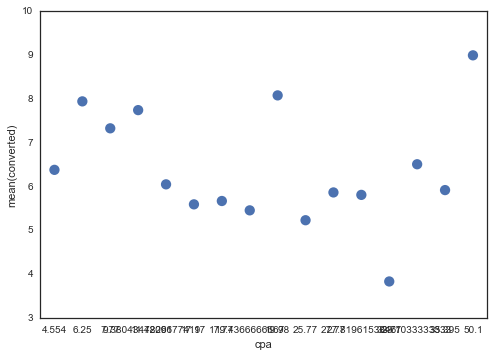

In [230]:
x = monthly_cpa.loc[monthly_cpa['campaign'] == 'Brazilian Cherry - BD', 'cpa']
sns.pointplot(x = x,
              y = monthly_conversions['converted'], 
              join = False);
fig.set_size_inches(8,6);

## Load campaign history from ad words

In [241]:
filepath = '/Users/lindsay/Documents/Data Science/BrazilianDirect/csv/adwords/campaign_report_23_march_2016.csv'
ads = pd.read_csv(filepath, skiprows = 1)

In [245]:
ads = ads.drop([30565, 30566, 30567, 30568, 30569], axis=0)

In [247]:
ads.columns = ['date', 'campaign_state', 'campaign', 'budget', 'status', 'impressions', 'interactions', 'interaction_types', 'interaction_rate', 'average_cost', 'cost', 'conversions', 'cost_per_conversion']

In [248]:
# format as date
ads['date'] = pd.to_datetime(ads['date'])

In [250]:
# add month and year
ads['month'] = [x.month for x in ads['date']]
ads['year'] = [x.year for x in ads['date']]

In [251]:
ads.head()

,date,campaign_state,campaign,budget,status,impressions,interactions,interaction_types,interaction_rate,average_cost,cost,conversions,cost_per_conversion,month,year
0,2016-03-03,enabled,Sucupira/Tiete Chestnut,27.77,eligible,58,2,Clicks,3.45%,0.42,0.83,0,0.00,3,2016
1,2016-03-11,enabled,Sucupira/Tiete Chestnut,27.77,eligible,104,7,Clicks,6.73%,0.63,4.38,1,4.38,3,2016
2,2016-03-12,enabled,Sucupira/Tiete Chestnut,27.77,eligible,95,5,Clicks,5.26%,0.64,3.22,0,0.00,3,2016
3,2016-03-13,enabled,Wenge,11,eligible,197,1,Clicks,0.51%,0.23,0.23,0,0.00,3,2016
4,2009-01-21,enabled,Sucupira/Tiete Chestnut,27.77,eligible,672,9,Clicks,1.34%,0.34,3.03,0,0.00,1,2009


In [268]:
# fix data types
ads['interaction_rate'] = [float(x.replace('%', '')) for x in ads['interaction_rate']]
ads['cost'] = ads['cost'].astype(float)
ads['conversions'] = ads['conversions'].astype(int)

In [307]:
ads['budget'] = ads['budget'].astype(float)

In [308]:
ads.dtypes

date                   datetime64[ns]
campaign_state                 object
campaign                       object
budget                        float64
status                         object
impressions                     int64
interactions                    int64
interaction_types              object
interaction_rate              float64
average_cost                  float64
cost                          float64
conversions                     int64
cost_per_conversion           float64
month                           int64
year                            int64
dtype: object

In [309]:
monthly_ads = ads.groupby(['campaign', 'year', 'month'])\
    .agg([np.mean, sum])\
    .reset_index()

In [310]:
monthly_ads = pd.DataFrame(monthly_ads.to_records())

In [311]:
monthly_ads = monthly_ads.drop('index', axis = 1)

In [312]:
monthly_ads.head()

,"('campaign', '')","('year', '')","('month', '')","('budget', 'mean')","('budget', 'sum')","('impressions', 'mean')","('impressions', 'sum')","('interactions', 'mean')","('interactions', 'sum')","('interaction_rate', 'mean')","('interaction_rate', 'sum')","('average_cost', 'mean')","('average_cost', 'sum')","('cost', 'mean')","('cost', 'sum')","('conversions', 'mean')","('conversions', 'sum')","('cost_per_conversion', 'mean')","('cost_per_conversion', 'sum')"
0,Amendoim,2009,1,44.77,1387.87,138.838710,4304,9.387097,291,7.004516,217.14,0.393226,12.19,3.667097,113.68,0.709677,22,1.367419,42.39
1,Amendoim,2009,2,44.77,1253.56,129.250000,3619,9.214286,258,7.127500,199.57,0.397500,11.13,3.595000,100.66,0.714286,20,1.692857,47.40
2,Amendoim,2009,3,44.77,1387.87,135.032258,4186,10.000000,310,7.573871,234.79,0.384194,11.91,3.794516,117.63,0.419355,13,1.481935,45.94
3,Amendoim,2009,4,44.77,1343.10,178.600000,5358,8.566667,257,4.938667,148.16,0.371333,11.14,3.126333,93.79,0.400000,12,0.898333,26.95
4,Amendoim,2009,5,44.77,1387.87,120.580645,3738,6.645161,206,5.563226,172.46,0.367419,11.39,2.482258,76.95,0.483871,15,1.234194,38.26


In [313]:
monthly_ads.columns = ['campaign', 
                       'year', 
                       'month', 
                       'budget',
                       'drop5',
                       'daily_impressions', 
                       'total_impressions',
                       'daily_interactions',
                       'total_interactions',
                       'interaction_rate',
                       'drop1',
                       'average_cost',
                       'drop2',
                       'mean_cost', 
                       'drop3',
                       'daily_conversions',
                       'total_conversions',
                       'cost_per_conversion', 
                       'drop4']

In [314]:
monthly_ads = monthly_ads.drop(['drop1', 'drop2', 'drop3', 'drop4', 'drop5'], axis=1)

In [315]:
monthly_ads.head()

,campaign,year,month,budget,daily_impressions,total_impressions,daily_interactions,total_interactions,interaction_rate,average_cost,mean_cost,daily_conversions,total_conversions,cost_per_conversion
0,Amendoim,2009,1,44.77,138.838710,4304,9.387097,291,7.004516,0.393226,3.667097,0.709677,22,1.367419
1,Amendoim,2009,2,44.77,129.250000,3619,9.214286,258,7.127500,0.397500,3.595000,0.714286,20,1.692857
2,Amendoim,2009,3,44.77,135.032258,4186,10.000000,310,7.573871,0.384194,3.794516,0.419355,13,1.481935
3,Amendoim,2009,4,44.77,178.600000,5358,8.566667,257,4.938667,0.371333,3.126333,0.400000,12,0.898333
4,Amendoim,2009,5,44.77,120.580645,3738,6.645161,206,5.563226,0.367419,2.482258,0.483871,15,1.234194


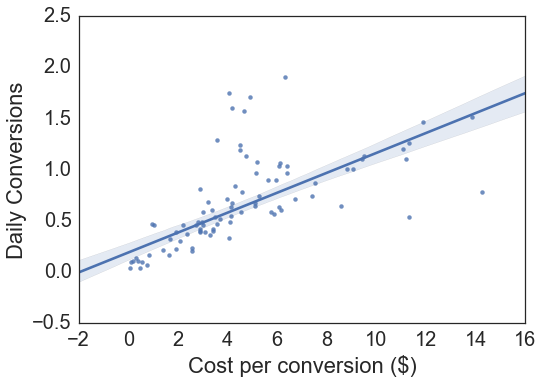

In [370]:
p = sns.regplot(x='cost_per_conversion',
              y='daily_conversions',
              data=monthly_ads.loc[monthly_ads['campaign'] == 'Brazilian Cherry - BD', :],
               robust=True);
# x = np.linspace(0, 100, 9)
# plt.xticks(x, x);
plt.ylabel('Daily Conversions');
plt.xlabel('Cost per conversion ($)');
fig.set_size_inches(8,6);

In [382]:
df_14_15_no_crazy.columns

Index([u'quote_id', u'email', u'date_created', u'days_until_needed',
       u'phone_provided', u'ship_state', u'install_subfloor', u'employee_id',
       u'sq_ft', u'cust_price', u'retail_price', u'common_name', u'finish',
       u'grade', u'milling', u'width', u'construction',
       u'days_until_needed_bin', u'sq_ft_bin', u'converted', u'month',
       u'year'],
      dtype='object')

In [383]:
pd.crosstab(df_14_15_no_crazy['sq_ft_bin'],[df_14_15_no_crazy['year'], df_14_15_no_crazy['converted']])

year       2014      2015    
converted     0   1     0   1
sq_ft_bin                    
0-500       744  75   664  47
501-1000   1264  98  1132  76
1001-1500   777  73   595  48
1501-2000   428  43   311  24
2001-5000   412  28   345  20
5001+        36   1    32   1

In [387]:
pd.crosstab(df_14_15_no_crazy['common_name'],[df_14_15_no_crazy['year'], df_14_15_no_crazy['converted']])

year                 2014       2015    
converted               0    1     0   1
common_name                             
Amendoim              162   22   110  10
Brazilian Cherry     1378  119  1273  89
Brazilian Teak        525   44   404  33
Brazilian Walnut      429   26   357  24
Other                  97    3    87   5
Patagonian Rosewood    94   17    99   6
Santos Mahogany       407   37   377  24
Tiete Rosewood        130   19    75   8
Tigerwood             441   32   297  17

year
2014    Axes(0.125,0.125;0.775x0.775)
2015    Axes(0.125,0.125;0.775x0.775)
Name: sq_ft, dtype: object

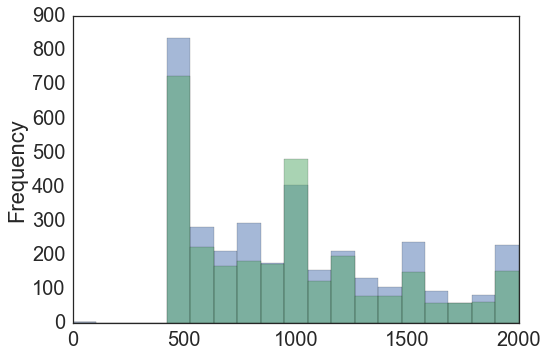

In [386]:
df_14_15_no_crazy.groupby('year')['sq_ft'].plot.hist(bins = np.linspace(0, 2000, 20), alpha=0.5)